In [1]:
import logging
import os
import numpy as np

from igibson.objects.articulated_object import URDFObject
from igibson.render.mesh_renderer.mesh_renderer_settings import MeshRendererSettings
from igibson.scenes.igibson_indoor_scene import InteractiveIndoorScene
from igibson.simulator import Simulator
from igibson.utils.assets_utils import (
    get_all_object_categories,
    get_ig_avg_category_specs,
    get_ig_model_path,
    get_object_models_of_category,
)
from igibson.utils.utils import let_user_pick


 _   _____  _  _
(_) / ____|(_)| |
 _ | |  __  _ | |__   ___   ___   _ __
| || | |_ || || '_ \ / __| / _ \ | '_ \
| || |__| || || |_) |\__ \| (_) || | | |
|_| \_____||_||_.__/ |___/ \___/ |_| |_|



/miniconda/envs/igibson/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Simplest debuggable problem: empty room, object, camera and world origin

In [3]:
from PIL import Image

def render(s, show=True, save=False, path='./images'):
    frame = s.renderer.render(modes=("rgb"))[0]
    rgb_image = (frame[..., :3] * 255).astype(np.uint8) 
    image = Image.fromarray(rgb_image)
    
    if show:
        image.show()
        
    if save:
        os.makedirs(path, exist_ok=True)
        image.save(os.path.join(path, f"tmp.jpg"), "JPEG")

INFO:igibson.render.mesh_renderer.get_available_devices:Device 0 is available for rendering
INFO:igibson.render.mesh_renderer.get_available_devices:Command '['/scratch/cs/world-models/dainesn1/iGibson/igibson/render/mesh_renderer/build/test_device', '1']' returned non-zero exit status 1.
INFO:igibson.render.mesh_renderer.get_available_devices:Device 1 is not available for rendering
INFO:igibson.render.mesh_renderer.get_available_devices:Command '['/scratch/cs/world-models/dainesn1/iGibson/igibson/render/mesh_renderer/build/test_device', '2']' returned non-zero exit status 1.
INFO:igibson.render.mesh_renderer.get_available_devices:Device 2 is not available for rendering
INFO:igibson.render.mesh_renderer.get_available_devices:Command '['/scratch/cs/world-models/dainesn1/iGibson/igibson/render/mesh_renderer/build/test_device', '3']' returned non-zero exit status 1.
INFO:igibson.render.mesh_renderer.get_available_devices:Device 3 is not available for rendering
INFO:igibson.render.mesh_rend

model_path:  /scratch/cs/world-models/dainesn1/iGibson/igibson/data/ig_dataset/objects/plate/plate_000
obj_name:  plate_0
[0.   0.   0.05]
[0.         0.         0.04319708]
[0.         0.         0.02552526]
[3.71344415e-04 4.20932662e-05 1.94545944e-02]
[2.76116538e-04 4.15886246e-05 1.97000603e-02]
[2.08914529e-04 4.14780144e-05 1.98755879e-02]
[1.61299585e-04 4.15300077e-05 2.00011847e-02]
[1.27461184e-04 4.16384417e-05 2.00910871e-02]
[1.03360455e-04 4.17566476e-05 2.01554559e-02]
[8.61679159e-05 4.18662401e-05 2.02015512e-02]
[7.38895062e-05 4.19617392e-05 2.02345648e-02]
[6.51136554e-05 4.20431420e-05 2.02582113e-02]
[5.88378419e-05 4.21124413e-05 2.02751496e-02]
[5.43483414e-05 4.21720750e-05 2.02872832e-02]
[5.11361424e-05 4.22242985e-05 2.02959753e-02]
[4.88377683e-05 4.22709820e-05 2.03022022e-02]
[4.71934288e-05 4.23135904e-05 2.03066631e-02]
[4.60173192e-05 4.23532343e-05 2.03098589e-02]
[4.51764870e-05 4.23907376e-05 2.03121484e-02]
[4.45757655e-05 4.24267036e-05 2.031378

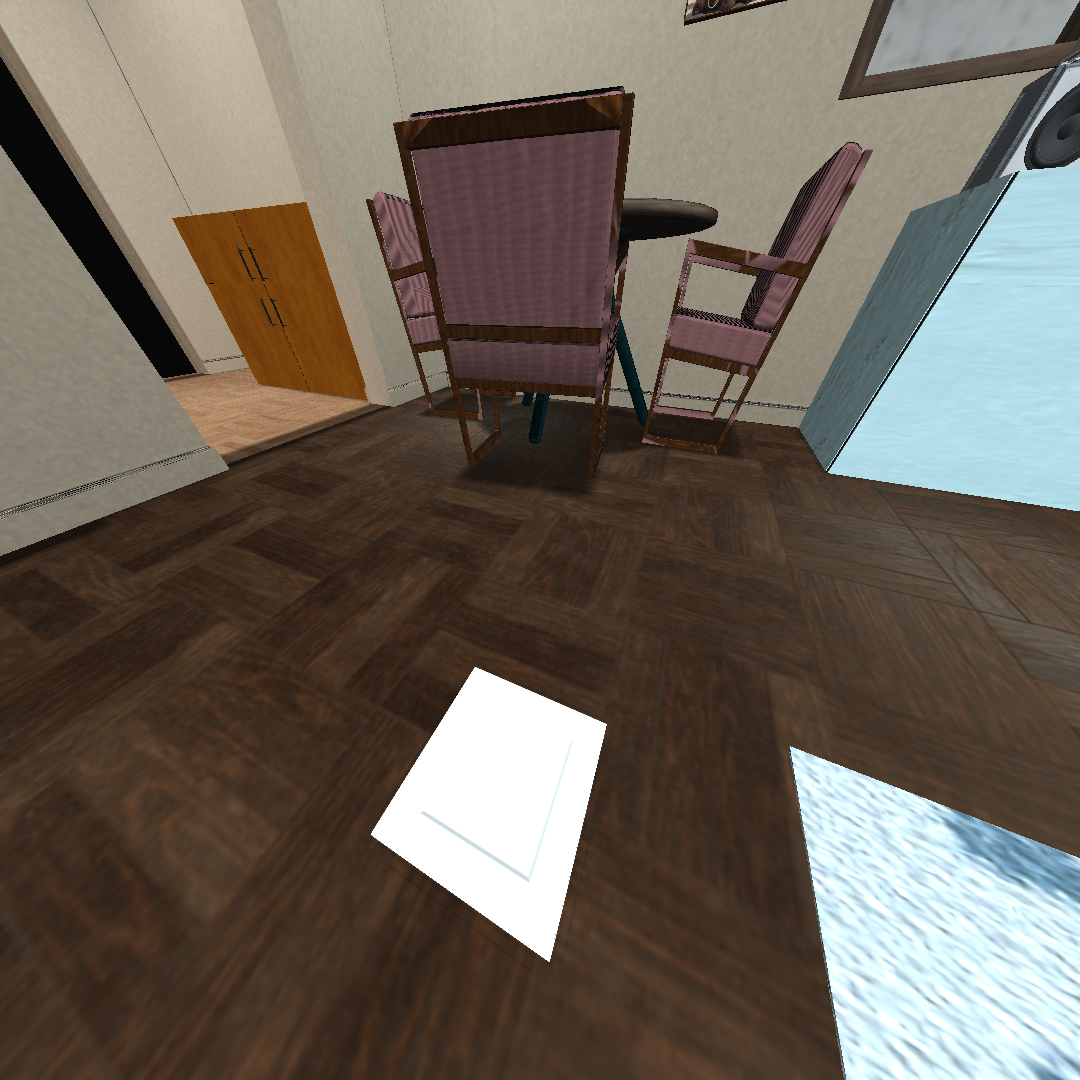

In [4]:
PHYSICS_STEPS = 30
logging.basicConfig(level=logging.INFO)

settings = MeshRendererSettings(enable_shadow=True, msaa=False, optimized=True)
s = Simulator(
    mode="headless",
    image_width=1080,
    image_height=1080,
    vertical_fov=70, # what is the vertical fov and how does that differ from camera_fov?
    rendering_settings=settings,
)

scene = InteractiveIndoorScene(
            "Rs_int",
            texture_randomization=False,
            load_object_categories=None,
            object_randomization=True,
            object_randomization_idx=0,
        )
s.import_scene(scene)
s.renderer.set_light_position_direction([0, 0, 10], [0, 0, 0])

# Select a category to load
obj_category = 'plate'#'apple'
obj_model = get_object_models_of_category(obj_category)[0] # list of all the 3d models of apple

# Load the specs of the object categories, e.g., common scaling factor
avg_category_spec = get_ig_avg_category_specs()

# Create the full path combining the path for all models and the name of the model
model_path = get_ig_model_path(obj_category, obj_model)
print("model_path: ", model_path)
filename = os.path.join(model_path, obj_model + ".urdf")

# Create a unique name for the object instance
obj_name = "{}_{}".format(obj_category, 0)
print("obj_name: ", obj_name)

# Create and import the object
simulator_obj = URDFObject(
    filename,
    name=obj_name,
    category=obj_category,
    model_path=model_path,
    avg_obj_dims=avg_category_spec.get(obj_category),
    fit_avg_dim_volume=True,
    texture_randomization=False,
    overwrite_inertial=True,
)
s.import_object(simulator_obj)
# the z might create problems if the apple overlaps with the floor
apple_pos = np.array([0.0, 0.0, 0.05])
simulator_obj.set_position(apple_pos) 

# Run some steps to let physics settle.
for _ in range(PHYSICS_STEPS):
    obj_pos = simulator_obj.get_position()
    print(obj_pos)
    s.step()

# See if this makes any difference
simulator_obj.set_position(apple_pos) 
obj_pos = simulator_obj.get_position()
print(obj_pos)

# Now let's add the camera as well
#camera_pos = np.array([0.0, -2.0, 0.05])
camera_pos = np.array([-0.1, -0.1, 0.55])
apple_pos = simulator_obj.get_position()
offset = np.array([1.0, 0.3, 0.1])
obj_direction = (apple_pos - camera_pos) + offset
obj_direction = obj_direction/np.linalg.norm(obj_direction) # Normalise
up_direction = np.array([0,0,1])
s.renderer.set_camera(camera_pos, obj_direction, up_direction)
s.renderer.set_fov(120)

# Finally render the scene -> it's a bit better
render(s)

In [5]:
from igibson.object_states.utils import get_center_extent
import random

def sample_position_on_aabb_face(target_obj):
    
    aabb_center, aabb_extent = get_center_extent(target_obj.states)
    # We want to sample only from the side-facing faces.
    face_normal_axis = random.choice([0, 1])
    face_normal_direction = random.choice([-1, 1])
    
    # Use half of the extent for the offset
    face_center = aabb_center + np.eye(3)[face_normal_axis] * (aabb_extent * 0.5) * face_normal_direction
    
    face_lateral_axis = 0 if face_normal_axis == 1 else 1
    face_lateral_half_extent = np.eye(3)[face_lateral_axis] * aabb_extent / 2
    face_vertical_half_extent = np.eye(3)[2] * aabb_extent / 2
    face_min = face_center - face_vertical_half_extent - face_lateral_half_extent
    face_max = face_center + face_vertical_half_extent + face_lateral_half_extent
    return np.random.uniform(face_min, face_max)

In [6]:
# How do we get the apple even if it's not a "task relevant" object?
# Still linked and updated
#simulator_obj.get_position()

# Now let's do the whole bounding box stuff to see where we start from
positions_on_obj_surface = []
for i in range(100):
    # this function sucks - yet it's the only one we have..
    pos_on_obj_surface = sample_position_on_aabb_face(simulator_obj)
    positions_on_obj_surface.append(pos_on_obj_surface)

# slight difference, at the end of the projection is like 1 pixel of difference
aabb_center, aabb_extent = get_center_extent(simulator_obj.states)
obj_pos = simulator_obj.get_position()
print("Object position: ", obj_pos)
print("AABB center: ", aabb_center)

Object position:  [0.   0.   0.05]
AABB center:  [ 2.53407000e-05 -7.82273872e-06  4.62404442e-02]


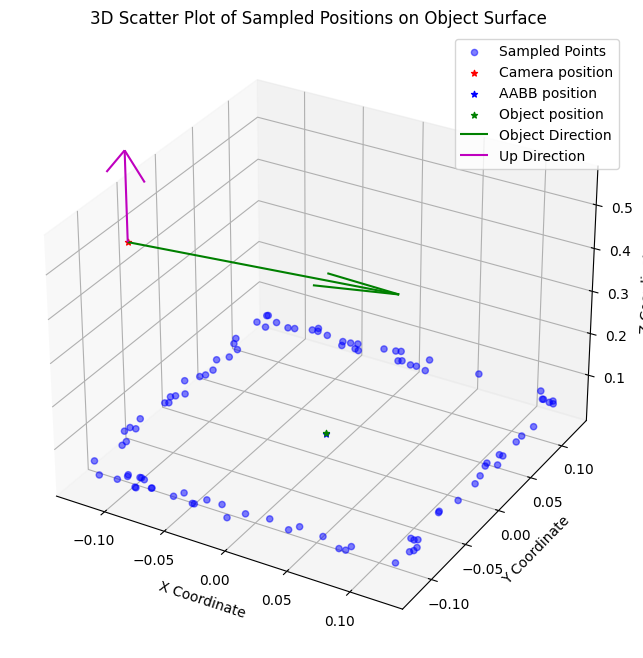

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Let's visualize the xyz coordinates as a 3D scatter plot
xyz = np.stack(positions_on_obj_surface)  # Shape (1000, 3)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c='b', marker='o', alpha=0.5, label="Sampled Points")

ax.scatter(camera_pos[0], camera_pos[1], camera_pos[2], c='r', marker='*', label='Camera position')
ax.scatter(aabb_center[0], aabb_center[1], aabb_center[2], c='b', marker='*', label='AABB position')
ax.scatter(obj_pos[0], obj_pos[1], obj_pos[2], c='g', marker='*', label='Object position')

# Add arrows for forward_downward_direction and up_direction
arrow_scale = 0.2  # Adjust for visibility

ax.quiver(camera_pos[0], camera_pos[1], camera_pos[2], 
          obj_direction[0], obj_direction[1], obj_direction[2], 
          color='g', length=arrow_scale, normalize=True, label="Object Direction")

ax.quiver(camera_pos[0], camera_pos[1], camera_pos[2], 
          up_direction[0], up_direction[1], up_direction[2], 
          color='m', length=arrow_scale, normalize=True, label="Up Direction")

# Labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("3D Scatter Plot of Sampled Positions on Object Surface")


ax.legend()
plt.show()

In [8]:
# Assuming is in world coordinates - move point to camera frame coordinates
# This is the most likely step to be wrong? Sanity check for camera works though!
objects_pos_camera_frame = [s.renderer.transform_point(obj_pos) for obj_pos in positions_on_obj_surface]
objects_pos_camera_frame = np.stack(objects_pos_camera_frame)
aabb_center_cf = s.renderer.transform_point(aabb_center)
print(obj_pos)
obj_center_cf = s.renderer.transform_point(obj_pos)
print(obj_center_cf)

[0.   0.   0.05]
[-0.05259028 -0.30549251 -0.4170235 ]


In [9]:
s.renderer.V

array([[ 0.39344528, -0.91934806,  0.        , -0.05259028],
       [ 0.5793589 ,  0.24794312,  0.7764454 , -0.34431478],
       [-0.71382356, -0.30548877,  0.63018453, -0.44853273],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [10]:
# Transform the two directions forward_downward and up
obj_direction_cf = s.renderer.transform_vector(obj_direction)
up_direction_cf = s.renderer.transform_vector(up_direction)

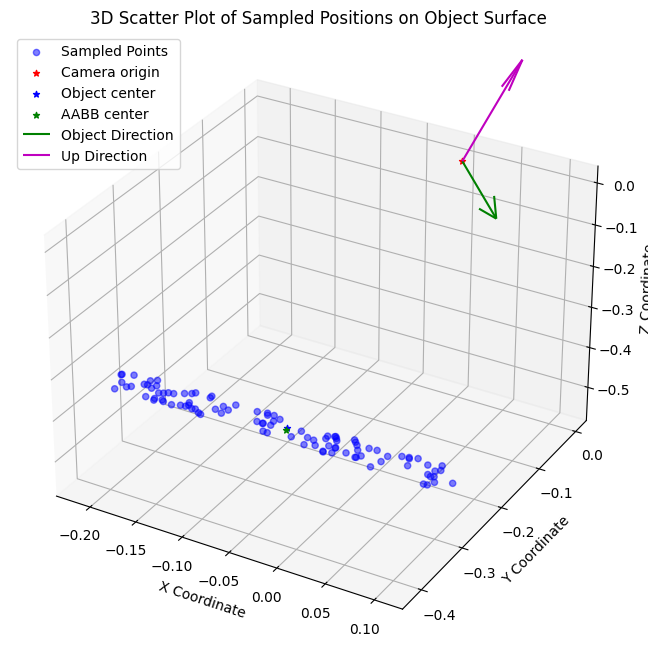

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Let's visualize the xyz coordinates as a 3D scatter plot
xyz = objects_pos_camera_frame  # Shape (1000, 3)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c='b', marker='o', alpha=0.5, label="Sampled Points")

ax.scatter(0,0,0, c='r', marker='*', label='Camera origin')
ax.scatter(obj_center_cf[0], obj_center_cf[1], obj_center_cf[2], c='b', marker='*', label='Object center')
ax.scatter(aabb_center_cf[0], aabb_center_cf[1], aabb_center_cf[2], c='g', marker='*', label='AABB center')

# Add arrows for forward_downward_direction and up_direction
arrow_scale = 0.2  # Adjust for visibility

ax.quiver(0, 0, 0, 
          obj_direction_cf[0], obj_direction_cf[1], obj_direction_cf[2], 
          color='g', length=arrow_scale, normalize=True, label="Object Direction")

ax.quiver(0, 0, 0, 
          up_direction_cf[0], up_direction_cf[1], up_direction_cf[2], 
          color='m', length=arrow_scale, normalize=True, label="Up Direction")

# Labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("3D Scatter Plot of Sampled Positions on Object Surface")

ax.legend()
plt.show()

In [12]:
# Project to uv plane
K = s.renderer.get_intrinsics()
print(K) # this is likely correct, as it has such interpretable parameters
uvw_column_vectors = np.dot(K, objects_pos_camera_frame.T)
print('uvw_column_vectors.shape', uvw_column_vectors.shape)
uv_prime_column_vectors = uvw_column_vectors[:2]/uvw_column_vectors[2:]
uv_prime = uv_prime_column_vectors.T

[[311.76913977   0.         540.        ]
 [  0.         311.76913977 540.        ]
 [  0.           0.           1.        ]]
uvw_column_vectors.shape (3, 100)


In [13]:
uvw_center = np.dot(K, obj_center_cf)
print(uvw_center)
uv_prime_center = uvw_center[:2]/uvw_center[2:]
uv_prime_center

[-241.58871748 -320.43583045   -0.4170235 ]


array([579.31678979, 768.38793868])

In [14]:
uvw_aabb_center = np.dot(K, aabb_center_cf)
uv_prime_aabb_center = uvw_aabb_center[:2]/uvw_aabb_center[2:]
uv_prime_aabb_center

array([579.08046239, 769.24968644])

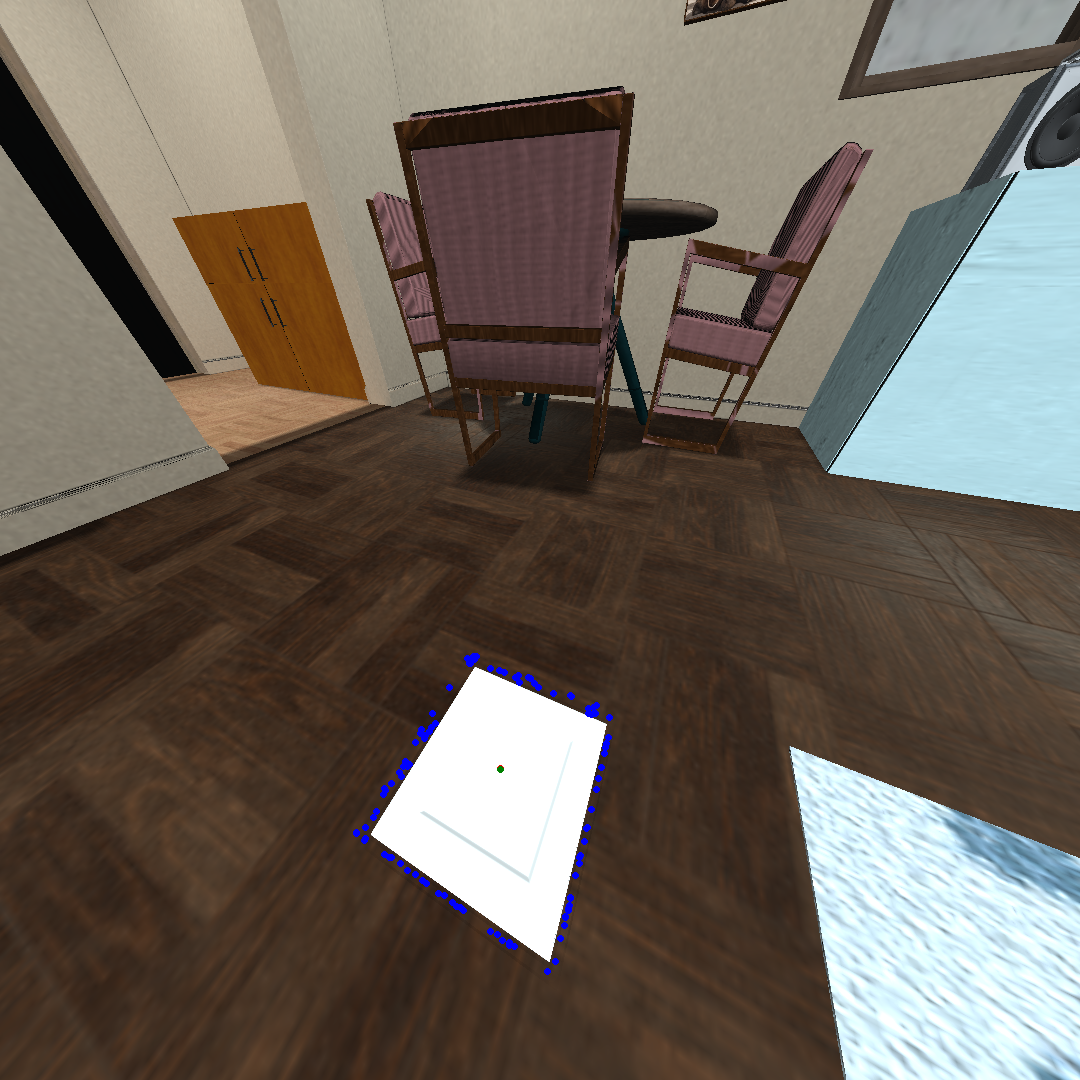

In [15]:
from PIL import ImageDraw

frame = s.renderer.render(modes=("rgb"))[0]
rgb_image = (frame[..., :3] * 255).astype(np.uint8) 

# Save using PIL
image = Image.fromarray(rgb_image)
draw = ImageDraw.Draw(image)

# Draw point
for (u,v) in uv_prime:
    r = 3  # Radius of the circle
    x = 1080 - u
    draw.ellipse([(x - r, v - r), (x + r, v + r)], fill="blue", outline="blue")

r = 3  # Radius of the circle
u, v = uv_prime_center
draw.ellipse([(1080 -u - r, v - r), (1080 - u + r, v + r)], fill="red", outline="red")

r = 3  # Radius of the circle
u, v = uv_prime_aabb_center
draw.ellipse([(1080 - u - r, v - r), (1080 - u + r, v + r)], fill="green", outline="green")

image.show()
image.save("images/tmp.jpg", "JPEG")